In [1]:
#Import libraries

import numpy as np

import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import datetime as dt

import matplotlib.pyplot as plt

In [2]:
# Database Setup
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# # inspect DB to see what tables we have
inspector = inspect(engine)
# inspector.get_table_names()

# Save reference to the tables
measurement = Base.classes.measurement
station = Base.classes.station

In [3]:
session = Session(engine)

In [4]:
# check out what is in the measurement table

m_data = pd.read_sql("SELECT * FROM measurement ORDER BY date DESC", engine.connect())
m_data.head()

# inspector.get_columns('measurement')

,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


In [5]:
# check out what is in the station table

s_data = pd.read_sql("SELECT * FROM station", engine.connect())
s_data.head()

# inspector.get_columns('station')

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Measurement Analysis

In [6]:
# find most recent date
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date[0], "%Y-%m-%d")
latest_date

datetime.datetime(2017, 8, 23, 0, 0)

In [7]:
# get last 12 months of data
query_date = latest_date - dt.timedelta(days=365)
query_date

datetime.datetime(2016, 8, 23, 0, 0)

In [8]:
# select data for last 12 months, save as DF
query1 = session.query(measurement.date, func.sum(measurement.prcp)).filter(measurement.date >= query_date).group_by(measurement.date).all() #order_by(measurement.date).all()
df_msr = pd.DataFrame(query1, columns=['date', 'prcp']).sort_values(by= 'date')
df_msr.set_index('date', inplace = True)
df_msr.head()

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


Text(0, 0.5, 'Inches')

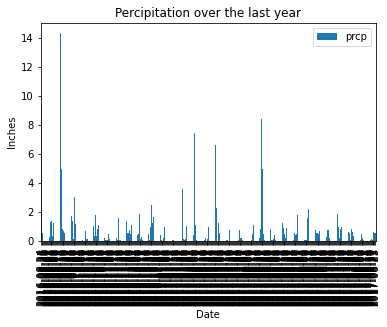

In [9]:
# plot the data
df_msr.plot.bar()
plt.title("Percipitation over the last year")
plt.xlabel("Date")
plt.ylabel("Inches")

# Station Analysis

In [10]:
# How many stations are there?
session.query(func.count(station.id)).all()
# session.query(station.id).distinct().all()

[(9)]

In [11]:
# Join the tables so we can count observations

sel = [measurement.station,
       station.name,
       measurement.date,
       measurement.prcp,
       measurement.tobs,
       station.latitude,
       station.longitude,
       station.elevation
      ]
columns = ['station','name','date','percipitation', 'temp','latitude','longitude','elevation']
joined = session.query(*sel).filter(measurement.station == station.station).all()

df_join = pd.DataFrame(joined, columns = columns)
df_join.head()

,station,name,date,percipitation,temp,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",2010-01-01,0.08,65.0,21.2716,-157.8168,3.0
1,USC00519397,"WAIKIKI 717.2, HI US",2010-01-02,0.00,63.0,21.2716,-157.8168,3.0
2,USC00519397,"WAIKIKI 717.2, HI US",2010-01-03,0.00,74.0,21.2716,-157.8168,3.0
3,USC00519397,"WAIKIKI 717.2, HI US",2010-01-04,0.00,76.0,21.2716,-157.8168,3.0
4,USC00519397,"WAIKIKI 717.2, HI US",2010-01-06,NaN,73.0,21.2716,-157.8168,3.0


In [12]:
# Find the most active station
sel = [measurement.station,
       func.count(measurement.date),
      ]
columns = [
    'Station', 
    'Number of Observations'
]
station_activity = session.query(*sel).filter(measurement.station == station.station).group_by(measurement.station).all()
station_activity = pd.DataFrame(station_activity, columns = columns)
# station_activity= station_activity.sort_values(by=['Number of Observations'], ascending = False)
# station_activity.head()

max_station = station_activity.loc[station_activity['Number of Observations'] == station_activity['Number of Observations'].max()]
max_station_id = max_station.iloc[0]['Station']
max_station_id

'USC00519281'

In [13]:
# Find the min, max, and average temp of the most active station
sel = [measurement.station,
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)
      ]
columns =['Station', 'Min Temp', 'Max Temp', 'Avg Temp']
df_maxstation = session.query(*sel).filter(measurement.station == station.station).filter(measurement.station == max_station_id).group_by(measurement.station).all()
df_maxstation = pd.DataFrame(df_maxstation, columns = columns)
df_maxstation.head()

,Station,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


In [14]:
# Get temp data from most active station for the latest 12 months
sel = [
       measurement.tobs
      ]
columns = ['temp'] 
df_max12 = session.query(*sel).filter(measurement.station == station.station).filter(measurement.date >= query_date).filter(measurement.station == max_station_id).all()
df_max12 = pd.DataFrame(df_max12, columns = columns)
df_max12.head()

,temp
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


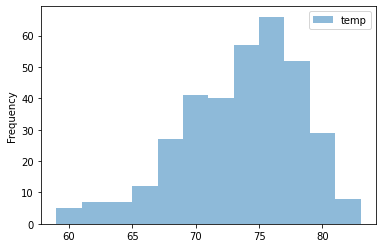

In [15]:
# Histogram
df_max12.plot.hist(bins=12, alpha=0.5)

In [16]:
# close session
session.close()